In [1]:
import sys

sys.path.insert(0, '../src')

from pysycomp import *

import matplotlib.pyplot as plt
import numpy as np

# The Gaussian Potential

We first must define the potential along with its parameters, as described below, given by Rossman et. al

### 1. The Potential

**Parameters**

$v_0 = 1$ Hartree

$\sigma = 0.1$ Angstrom

**Potential**

$V(q)=-v_0*e^{(\frac{-q^2}{2*\sigma^2})}$

We can define this potential as `potential`, and define the given parameters as `D`, `alpha`, and `q_0` as described below. We will also need to define the dependent variable, in this case `q` as a range using the `linspace` function found in `numpy`. The parameters are all in *atomic units*.

In [2]:
v_0 = 5 # Hartree
sigma = 0.75 # Angstrom
sigma1 = 1.5

q = np.linspace(-5, 5, 1000)

alpha1 = 1/(2*sigma1**2)
alpha = 1/(2*sigma**2)

potential = -v_0*np.exp(-q**2*alpha)
potential1 = -v_0*np.exp(-alpha1*q**2)

Now that the parameters and potential have been defined, the potential can be plotted using the `matplotlib.pyplot` library. Any of the lines can be changed as desired.

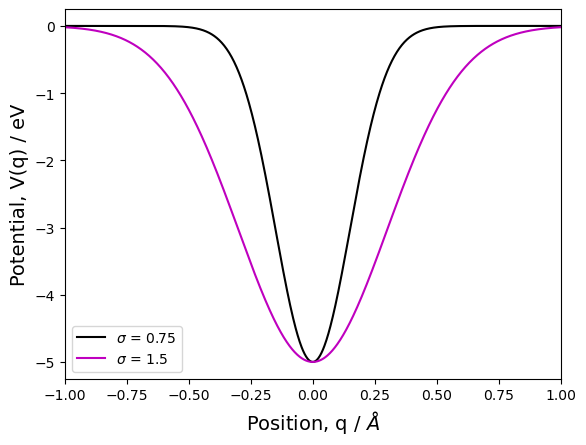

In [3]:
q = np.linspace(-1, 1, 1000)
plt.plot(q, potential, 'k')
plt.plot(q, potential1, "m")
plt.legend([r"$\sigma$ = 0.75", r"$\sigma$ = 1.5"])
plt.xlim(-1, 1)
plt.xlabel("Position, q / $\AA$", fontsize=14)
plt.ylabel("Potential, V(q) / eV", fontsize=14)
#plt.savefig("gaussian_vVq.png")
plt.show()

### 2. Derivation of  QHD formulas

Here, we use the pysces library, able to derive the equations of motion in the QHD method. We will need to define the `q`, `p`, `p2`, `x`, `x2`, and `xp` variables. In order to do this, we must first calculate the first and second derivatives of the potential of interest, defined in section 1. We will also use a change of variables as well, described below.

**2.1 The First and Second Derivatives of the Potential**

To take the derivatives, we must represent the potential symbolically. This can be done by:

In [4]:
# First, we must define all the parameters as stated in section 1 as symbols:

v_0, sigma, q, alpha = symbols("v_0, sigma q alpha")

# When computing symbolically, we do not need to use the numpy exponential function.

potential_sym = -v_0*exp(-alpha*q**2)


Now that the potential is represented symbolically, we may take the first and second derivatives, described by diff1 and diff2, respectively

In [5]:
diff1 = diff(potential_sym, q)
diff2 = diff(diff1, q)

diff1, diff2

**2.2 Change of Variable**

We can do a change of variable in the potential to:

$$x=e^{-\alpha*q^2}$$

And so:

$$V(q)=A*x$$

We will now take the first and second derivatives of the original potential, and then perform the change of variables.

- The First Derivative:

In [6]:
x = Symbol("x")

diff11 = diff1.replace(exp(-alpha*q**2), x)

diff11

- The Second Derivative:

In [7]:
diff22 = diff2.replace(exp(-alpha*q**2), x)

diff22

**2.3 Solving for the Equations of Motion**

We must solve the equations of motion for `q`, `p`, `x`, `x2`, and `xp` using the parameters defined in section 1.

In [8]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma, q2 = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma q2")
q_0 = 0.0

########## EOM Calculations ##########

# If you want to see the output of any of the below, uncomment the desired print line. #

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
#print("q = " + str(q1))

q21 = str(time_deriv(q, 2)*dt + q2)
#print(q21)

x = exp(-alpha*q**2)
x1 = sympify(str(time_deriv(x, 1)).replace("exp(-alpha*q**2)", "x"))
x1 = str((symmetrize(x1))*(0.5)*dt + Symbol("x"))
x1 = str(x1).replace("p*q*x", "q*xp")
#print("x = " + str(x1))

p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1).replace("exp(-2.0*q**2)", "x2").replace("alpha**2", "0")
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p).replace("exp(-alpha*q**2)", "x")
#print("p = " + str(p1))

x = Symbol("x")
p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(p21).replace("exp(-alpha*q**2)", "x").replace("exp(-2*alpha*q**2)", "x2").replace("alpha**2", "0")
p21 = str(symmetrize(p21)*(0.5)*dt + p2).replace("exp(-alpha*q**2)", "x").replace("exp(-2.0*q**2)", "x2")
p21 = str(p21).replace("p*q*v_0*x", "v_0*q*xp")
#print("p2 = " + str(p21))

### Please note these last two need to be in functions to work properly.
alpha = Symbol("alpha")

def integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,dt,mass,alp,D):
    x2 = x2 - (q*alpha*x*(xp - x*p))/mass*0.5*dt #4.0*(alp/mass)*x*(xp - x*p)*0.5*dt
    x2 = exp(-2.0*alp*(dt*p/mass)**2)*x2
    x2 = x2 - (q*alpha*x*(xp - x*p))/mass*0.5*dt  #4.0*(alp/mass)*x*(xp - x*p)*0.5*dt
    return x2

def integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,dt,mass,alp,D):
    xp = xp + 0.5*dt*(alpha*((x*(p2-2*p*p)))/(-2*mass) - (-v_0*x2*2*alpha*q+v_0**2*4*alpha**2*q2*x2))#0.5*dt*(2.0*alp*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alp*x/mass)*(p2 - 2.0*p*p) )
    xp = exp(-2*alpha*(dt*p/mass)**2)*xp
    xp = xp + 0.5*dt*(alpha*((x*(p2-2*p*p)))/(-2*mass) - (-v_0*x2*2*alpha*q+v_0**2*4*alpha**2*q2*x2))#0.5*dt*(2.0*alp*D*(x*(3.0*x2 - 2*x*x) - x2)  - (alp*x/mass)*(p2 - 2.0*p*p) )
    return xp

Now, we are ready to make plots of the data based on the EOM's as computed above.

# 3. Graphing

**3.1 Generating Time-Dependent Values**

We will first define all of the parameters necessary to perform the QHD calculations as followed:

`hbar`: Plancks constant

`convert`: A conversion factor for the mass

`mass`: The mass of the particle in the potential. In this case, the mass of a hydrogen atom is used.

`q0`: The starting position value

`p0`: The starting momentum value

`s0`: The mean width

`ps0`: The mean width momentum

`sigma`: A constant in the guassian potential

`alp` (`alpha`): A constant in the gaussian potential

`D`: A constant in the gaussian potential

`dt`: The time step used

In [9]:
##### Constants #####

v_0 = 5 # Hartree
sigma = 1.5 # Angstrom
mass = 1836 # a.u.
hbar = 0.6582  # eV * fs
convert = (1.0/17.586)


# Feel free to change any of the below parameters to observe what happens when you change them
mass =  2980.0*convert
q0 = 0.15
p0 = 0.0
s0 = 0.05
ps0 = 0.0

dt = 0.1
alpha = 1/(2*sigma**2)
alp = alpha

**Q1.** How does the `alpha` parameter change the potential, qualitatively?

Below, the initial conditions are described. These initial conditions describe a gaussian wavepacket, and do not need to be changed.

In [10]:
##### Initial Conditions (Do Not Change) #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = exp(-alp*q0**2)*exp(0.5*alp*alp*s0*s0)
x2 = exp(-2.0*alp*q0**2)*exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

##### ----- #####

xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
x = eval(x1)
p2 = eval(p21)
q2 = eval(q21)
p = eval(p1)
q = eval(q1)
p = eval(p1)
q2 = eval(q21)
p2 = eval(p21)
x = eval(x1)
x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

Below, empty lists are created to store the data generated. Feel free to create your own lists to examine how different variables change over time.

In [11]:
##### Empty Lists for Data Storage: #####

q_list = [] 
p_list = []

**Q2.** Create an empty list for `p2` and `q2` values and observe how this variable changes over time.

Now that the parameters have been defined, we can compute the desired values of position and energy over a given time interval.

**Q3.** Try changing the time step (`dt`) or the finish time (`t_f`). For running dissociation, only run for `t_f=19`

In [12]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish


#### --- Do Not Change Anything Below --- #####

### Compute the y values ###

while t_i<=t_f:
    xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
    x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
    x = eval(x1)
    p2 = eval(p21)
    q2 = eval(q21)
    p = eval(p1)
    q = eval(q1)
    p = eval(p1)
    q2 = eval(q21)
    p2 = eval(p21)
    x = eval(x1)
    x2 = integrate_x2(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)
    xp = integrate_xp(q,p,pq,q2,p2,x,x2,xp,xq,0.5*dt,mass,alp,D)

    t_i = t_i + dt

##### --- #####

    # Here is where you add the lists to store data
    
    q_list.append(q)
    p_list.append(p)

### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 32.002883195877075


For the x values, we create a range with `(t_i, t_f, dt)` as the parameters. Due to the increasing nature of `t_i`, the initial value of `0.0` is used in its place.

In [13]:
### Define the x values ###

x_list = np.arange(0, t_f, dt)

**3.2 Graphing Position versus Time**

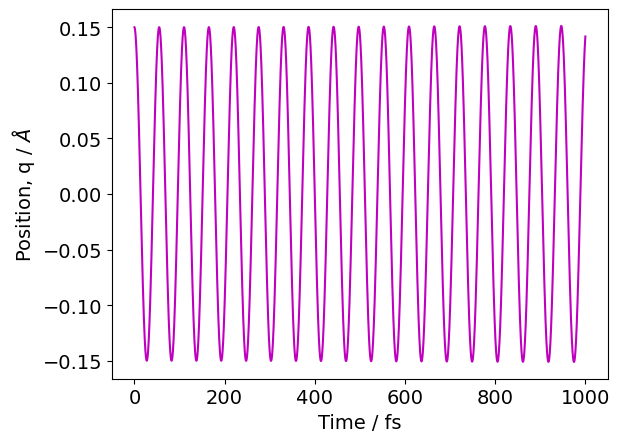

In [14]:
plt.plot(x_list, q_list, 'm')
#plt.xlim(0, 20)
#plt.ylim(-0.8, 1.5)
plt.xlabel("Time / fs", fontsize=14)
plt.ylabel("Position, q / $\AA$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('gaussian_qVt_15.png')
plt.show()

**3.3 Graphing Momentum versus Time**

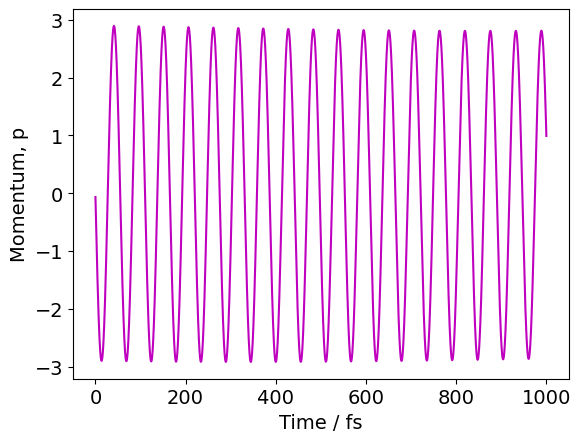

In [15]:
plt.plot(x_list, p_list, 'm')
#plt.xlim(0, 20)
#plt.ylim(-0.8, 30)
plt.xlabel("Time / fs", fontsize=14)
plt.ylabel("Momentum, p", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('gaussian_pVt_15.png')
plt.show()

**Q4.** How does increasing `sigma` to `1.5` affect the position and momentum?

**Q5.** How does changing the starting position, `q0`, affect the position versus time? At what value of `q0` does the particle dissociate?

# 4. Comparing to Classical Equations of Motion

Here, you will compare classical equations of motion to the QHD equations of motion as described in the previous sections. In order to do this, we must repeat some of the above codes.

**Q6.** What do you predict the classical plot to look like? The QHD plot?

In [16]:
# Again, we must first define all variables as symbols. #

q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma, q2 = symbols("q, p, p2, x, x2, xp, dt, mass, D, alpha, sigma q2")
q_0 = 0.0

########## EOM Calculations ##########

# If you want to see the output of any of the below, uncomment the desired print line. #

# There are two ways to derive the EOM's, using the `time_deriv` function and then the original way is with `QHD_int`
# The `time_deriv` function is used as it's more versatile at this time, however it's still not perfect.
# `QHD_int` uses the `time_deriv` function

px = xp
q1 = str(time_deriv(q, 1)*dt + q)
print("q = " + str(q1))

q21 = str(time_deriv(q, 2)*dt + q2)
print(q21)

p1 = str(time_deriv(p, 1)).replace("v(q)", str(potential_sym))
p1 = expand(sympify(p1).doit())
p1 = str(p1)
p1 = sympify(p1)
p1 = str(symmetrize(p1)*(0.5)*dt + p)
print("p = " + str(p1))

p21 = str(time_deriv(p, 2)).replace("v(q)", str(potential_sym))
p21 = expand(sympify(p21).doit())
p21 = str(p21)
p21 = str(symmetrize(p21)*(0.5)*dt + p2)
p21 = str(p21)
print("p2 = " + str(p21))

q = dt*p/mass + q
2*dt*p*q/mass + q2
p = -1.0*alpha*dt*q*v_0*exp(-alpha*q**2) + p
p2 = -2.0*alpha*dt*p*q*v_0*exp(-alpha*q**2) + p2


In [17]:
##### Constants #####

v_0 = 5 # Hartree
sigma = 0.75 # Angstrom
mass = 1836 # a.u.

# Feel free to change any of the below parameters to observe what happens when you change them
hbar = 0.6582  # eV * fs
convert = (1.0/17.586)
mass =  2980.0*convert
q0 = 0.15
p0 = 0.0
s0 = 0.05
ps0 = 0.0

dt = 0.1
alpha = 1/(2*sigma**2)
alp = alpha

In [18]:
##### Initial Conditions (Do Not Change) #####

t = 0.0    
Etot = 0.0
Etot0 = 0.0
Etot_cl = 0.0
Etot_cl0 = 0.0
q,p,pq,q2,p2,x,x2,xp,xq = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
q, p = q0, p0
q_0 = 0.0
q2 = q*q + s0*s0
pq = ps0*s0 + q*p
p2 = p*p + ps0*ps0 + (0.5*hbar/s0)**2
x = exp(-alp*q0)*exp(0.5*alp*alp*s0*s0)
x2 = exp(-2.0*alp*q0)*exp(2.0*alp*alp*s0*s0)
xq = x*(q-alp*s0*s0)
xp = x*(p - s0*ps0*alp)

##### ----- #####

p2 = eval(p21)
q2 = eval(q21)
p = eval(p1)
q = eval(q1)
p = eval(p1)
q2 = eval(q21)
p2 = eval(p21)

In [19]:
##### Empty Lists for Data Storage: #####

q_list_classical = [] 
p_list_classical = []

In [20]:
### Time how long it takes to compute ###

import time 
begin = time.time()


### Compute the x values ###

dt = 0.1 # step size
t_i = 0.0 # start
t_f = 1000 # finish


### Compute the y values ###

while t_i<=t_f:

    p2 = eval(p21)
    q2 = eval(q21)
    p = eval(p1)
    q = eval(q1)
    p = eval(p1)
    q2 = eval(q21)
    p2 = eval(p21)

    t_i = t_i + dt
    
    # Here is where you add the lists to store data
    q_list_classical.append(q)
    p_list_classical.append(p)

### Compute the end time ###
    
time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime is {end - begin}")

Total runtime is 15.369691371917725


In [21]:
x_list_classical = np.arange(0, t_f, dt)

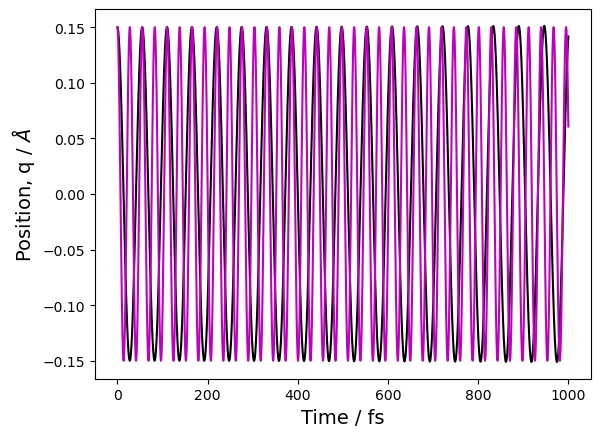

In [22]:
plt.plot(x_list, q_list, 'k')
plt.plot(x_list_classical, q_list_classical, "m")
#plt.xlim(0, 40)
plt.xlabel("Time / fs", fontsize=14)
#plt.ylim(-2, 1.5)
plt.ylabel("Position, q / $\AA$", fontsize=14)
#plt.savefig('gaussian_qVt_classical_dissoc.png')
plt.show()

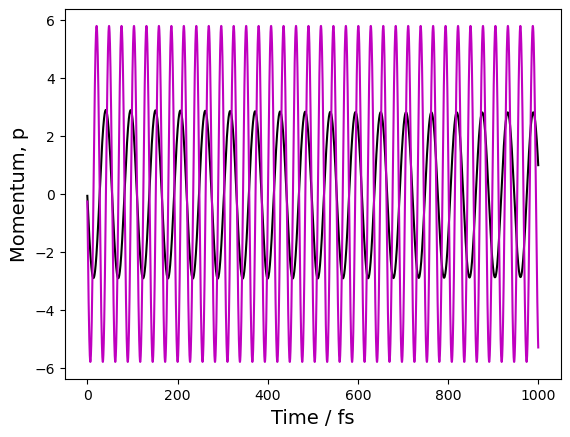

In [23]:
plt.plot(x_list, p_list, 'k')
plt.plot(x_list_classical, p_list_classical, "m")
#plt.xlim(0, 40)
plt.xlabel("Time / fs", fontsize=14)
#plt.ylim(-30, 40)
plt.ylabel("Momentum, p", fontsize=14)
#plt.savefig('gaussian_pVt_classical_dissoc.png')
plt.show()